In [1]:
##########################Load Libraries  ####################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt     
import re
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error
from Data_Processing import reduce_memory_usage

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence 

from window_data import *

import os, errno
import sys
from tqdm import trange


import warnings
warnings.filterwarnings('ignore')

### Pre Processing & Dataset Preparation

#### GPU use
Emply GPU to accelerate the training of the deep learning model.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Load and Clean Data

Data is stored in csv files. We will only consider traces where Csv_breath_hold and Data_breath_hold differs by fewer than 2 seconds

In [4]:
breath_df = pd.read_pickle('breath_df')
under2 = breath_df[abs(breath_df['Csv_breath_holds']\
                       -breath_df['Data_breath_holds'])<=2].reset_index()

In [4]:
under2.head()

,index,Trace,Csv_breath_holds,Data_breath_holds,Full_trace,breathhold_idx,bh_start_end
0,0,"[0.1319, 0.1363, 0.1408, 0.1452, 0.1497, 0.154...",31.29,31.69,"[0.0003, 0.0006, 0.001, 0.0014, 0.0019, 0.0023...","[2661, 2662, 2663, 2664, 2665, 2666, 2667, 266...","(2661, 5829)"
1,1,"[0.4727, 0.4687, 0.4646, 0.4605, 0.4563, 0.452...",30.61,31.40,"[0.0006, 0.0009, 0.0013, 0.0017, 0.0022, 0.002...","[2386, 2387, 2388, 2389, 2390, 2391, 2392, 239...","(2386, 5525)"
2,3,"[0.0982, 0.0966, 0.095, 0.0934, 0.0919, 0.0904...",30.85,31.84,"[0.0013, 0.0027, 0.0034, 0.0041, 0.005, 0.006,...","[2573, 2574, 2575, 2576, 2577, 2578, 2579, 258...","(2573, 5756)"
3,4,"[0.0117, 0.0109, 0.0102, 0.0095, 0.0089, 0.008...",32.12,32.53,"[0.0012, 0.0015, 0.0019, 0.0023, 0.0029, 0.003...","[2520, 2521, 2522, 2523, 2524, 2525, 2526, 252...","(2520, 5772)"
4,5,"[0.1155, 0.1195, 0.1235, 0.1276, 0.1317, 0.135...",30.88,31.02,"[0.0008, 0.0011, 0.0014, 0.0018, 0.0023, 0.002...","[2683, 2684, 2685, 2686, 2687, 2688, 2689, 269...","(2683, 5784)"


#### Only Consider Regular Breathing

In [5]:
under2['start_idx'] = \
            [bh_range[0] for bh_range in under2['bh_start_end']]

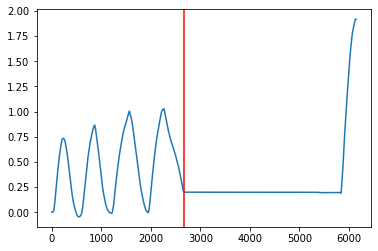

In [6]:
plt.plot(under2['Full_trace'][0])
plt.axvline(2661, c='red')
plt.show()

In [7]:
regular_breathing = []
for i in range(len(under2)):
    bh_start = under2['start_idx'][i]
    trace = under2['Full_trace'][i]
    regular_breathing.append(trace[:bh_start])
under2['regular_breathing'] = regular_breathing

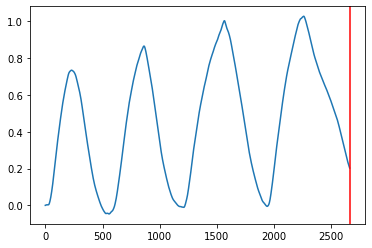

In [8]:
plt.plot(under2['regular_breathing'][0])
plt.axvline(2661, c='red')
plt.show()

#### Memory Usage 

In [9]:
under2 = reduce_memory_usage(under2)

Mem. usage decreased to  0.22 Mb from  0.33 Mb (33.3% reduction)


In [10]:
df = under2.copy()

In [11]:
df.head(2)

,index,Trace,Csv_breath_holds,Data_breath_holds,Full_trace,breathhold_idx,bh_start_end,start_idx,regular_breathing
0,0,"[0.132, 0.1364, 0.1407, 0.1451, 0.1497, 0.1543...",31.296875,31.68750,"[0.0003, 0.0006, 0.001, 0.0014, 0.0019, 0.0023...","[2660.0, 2662.0, 2664.0, 2664.0, 2664.0, 2666....","[2660.0, 5828.0]",2661,"[0.0003, 0.0006, 0.001, 0.0014, 0.0019, 0.0023..."
1,1,"[0.4727, 0.4688, 0.4646, 0.4604, 0.4563, 0.452...",30.609375,31.40625,"[0.0006, 0.0009, 0.0013, 0.0017, 0.0022, 0.002...","[2386.0, 2388.0, 2388.0, 2388.0, 2390.0, 2392....","[2386.0, 5524.0]",2386,"[0.0006, 0.0009, 0.0013, 0.0017, 0.0022, 0.002..."


In [12]:
df['regular_breathing']

0       [0.0003, 0.0006, 0.001, 0.0014, 0.0019, 0.0023...
1       [0.0006, 0.0009, 0.0013, 0.0017, 0.0022, 0.002...
2       [0.0013, 0.0027, 0.0034, 0.0041, 0.005, 0.006,...
3       [0.0012, 0.0015, 0.0019, 0.0023, 0.0029, 0.003...
4       [0.0008, 0.0011, 0.0014, 0.0018, 0.0023, 0.002...
                              ...                        
4788    [0.0003, 0.0007, 0.0012, 0.0016, 0.002, 0.0023...
4789    [0.0015, 0.0019, 0.0024, 0.0032, 0.0041, 0.005...
4790    [0.0002, 0.0005, 0.0009, 0.0014, 0.0021, 0.002...
4791    [0.0019, 0.0024, 0.0031, 0.004, 0.0051, 0.0064...
4792    [0.0031, 0.0038, 0.0049, 0.0063, 0.0081, 0.010...
Name: regular_breathing, Length: 4793, dtype: object

#### Split Data

In [13]:
train_size = int((len(df)) * 0.70)
valid_size = int((len(df))*.20)
test_size = int((len(df))*.10)
print("train size is:",train_size)
print("validation size is:",valid_size)
print("test size is:",test_size)

train size is: 3355
validation size is: 958
test size is: 479


In [14]:
train = df.iloc[0:train_size]
valid = df.iloc[train_size:train_size+valid_size]
test = df.iloc[train_size+valid_size:]
print("train data shape is:",train.shape)
print("validation data shape is:",valid.shape)
print("test data shape is:",test.shape)

train data shape is: (3355, 9)
validation data shape is: (958, 9)
test data shape is: (480, 9)


#### Normalize Data`

In [20]:
X_train = list(train['Trace'])
X_val = list(valid['Trace'])
X_test = list(test['Trace'])

In [21]:
scaler = StandardScaler() # creates the scaler
scaler.fit(X_train)
x_train2 = scaler.transform(X_train)
x_val2 = scaler.transform(X_val)
x_test2 = scaler.transform(X_test)

In [59]:
# -1 1

#### Sliding Window

We wil use a sliding window of 100 points.
Our target(labels) is 10 points

In [22]:
num_outputs = 10

In [24]:
Train = create_windowed_data(n_steps=100, num_outputs=num_outputs, dataset=x_train2)
Valid = create_windowed_data(n_steps=100, num_outputs=num_outputs, dataset=x_val2)
Test = create_windowed_data(n_steps=100, num_outputs=num_outputs, dataset=x_test2)

#### Define Dataset

Convert data to tensors

In [31]:
def reshape_series(series):
    series = np.transpose(np.array(series))
    return series.reshape(series.shape[0],series.shape[1], 1)

x_train = reshape_series(list(Train['Trace']))
x_val = reshape_series(list(Valid['Trace']))
x_test = reshape_series(list(Test['Trace']))
y_train = reshape_series(list(Train['Next_pts']))
y_val = reshape_series(list(Train['Next_pts']))
y_test = reshape_series(list(Test['Next_pts']))

In [32]:
#dataset
from torch.utils.data import Dataset

In [33]:
from torch.utils.data import Dataset

class timeseries(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len

In [34]:
train_dataset = timeseries(x_train, y_train)
valid_dataset = timeseries(x_val, y_val)
test_dataset = timeseries(x_test, y_test)

In [35]:
print ("train X shape is:",train_dataset.x.shape)
print ("train y shape is:",train_dataset.y.shape)

train X shape is: torch.Size([100, 43615, 1])
train y shape is: torch.Size([10, 43615, 1])


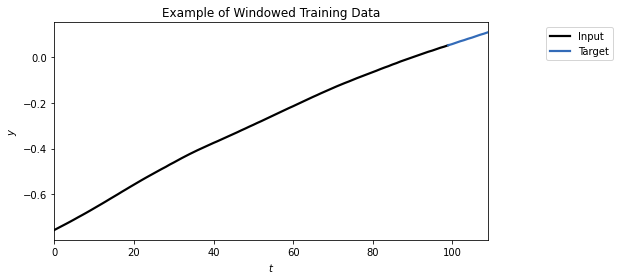

In [38]:
iw = 100
ow = 10 
# plot example of windowed data  
plt.figure(figsize = (9, 4)) 
plt.plot(np.arange(0, iw), x_train[:, 0, 0], 'k', linewidth = 2.2, label = 'Input')
plt.plot(np.arange(iw - 1, iw + ow), np.concatenate([[x_train[-1, 0, 0]], y_train[:, 0, 0]]),
         color = (0.2, 0.42, 0.72), linewidth = 2.2, label = 'Target')
plt.xlim([0, iw + ow - 1])
plt.xlabel(r'$t$')
plt.ylabel(r'$y$')
plt.title('Example of Windowed Training Data')
plt.legend(bbox_to_anchor=(1.3, 1))
plt.tight_layout() 

### Model Definition

#### Define LSTM Encoder and Decoder (Multistep Prediction)

In [39]:
# neural network
from torch import nn

class lstm_encoder(nn.Module):
    ''' Encodes a time series sequence '''
    
    def __init__(self, input_size=1, hidden_size=5, num_layers=1):

        super(lstm_encoder, self).__init__()
        self.input_size = input_size # the number of features in the input X
        self.hidden_size = hidden_size # the number of features in the hidden state h
        self.num_layers = num_layers # number of recurrent layers 
        
        # define an LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers)
        
    def forward(self, x):
        output, self.hidden = self.lstm(x.view(x.shape[0], x.shape[1], self.input_size))
        
        return output, self.hidden   # hidden gives the hidden state and cell state for the last element in the sequence 
                                     # give this to decoder
    
    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))
    
        

In [40]:
class lstm_decoder(nn.Module):
    ''' Decodes hidden state output by encoder '''
    
    def __init__(self, input_size=1, hidden_size=5, num_layers=1):

        super(lstm_decoder, self).__init__()
        self.input_size = input_size   # the number of features in the input X
        self.hidden_size = hidden_size # the number of features in the hidden state h
        self.num_layers = num_layers   # number of recurrent layers

        # Define LSTM layer and Linear layer
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, input_size)       
    
    
    def forward(self, x, encoder_hidden_states):
        output, self.hidden = self.lstm(x.unsqueeze(0), encoder_hidden_states)
        output = self.linear(output.squeeze(0))     
        
        return output, self.hidden


#### Define Seq2Seq Model (Combining encoder and decoder)

In [41]:
class lstm_seq2seq(nn.Module):
    ''' train LSTM encoder-decoder and make predictions '''
    
    def __init__(self, input_size=1, hidden_size=5):

        super(lstm_seq2seq, self).__init__()

        self.input_size = input_size   # number of expected features in the input X
        self.hidden_size = hidden_size # number of features in the hidden state h
        
        # Encoder and decoder
        self.encoder = lstm_encoder(input_size=input_size, hidden_size=hidden_size)
        self.decoder = lstm_decoder(input_size=input_size, hidden_size=hidden_size)
    
    
    def val_metrics(self, input_tensor, target_tensor, batch_size=200, criterion=nn.MSELoss(), target_len=10):

        # calculate number of batch iterations
        n_batches = int(input_tensor.shape[1] / batch_size)

        val_batch_loss = 0.
        val_batch_mae = 0.
                
        for b in range(n_batches):
            input_batch = input_tensor[:, b: b + batch_size, :]
            target_batch = target_tensor[:, b: b + batch_size, :]

            # outputs tensor
            outputs = torch.zeros(target_len, batch_size, input_batch.shape[2])

            # initialize hidden state
            encoder_hidden = self.encoder.init_hidden(batch_size)
            encoder_output, encoder_hidden = self.encoder(input_batch)

            # decoder with teacher forcing
            decoder_input = input_batch[-1, :, :] 
            decoder_hidden = encoder_hidden

            for t in range(target_len): 
                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                outputs[t] = decoder_output
                decoder_input = decoder_output

            # compute the loss 
            loss = criterion(outputs, target_batch)
            val_batch_loss += loss.item()
            
            # compute mae
            mae_func = nn.L1Loss()
            mae = mae_func(outputs, target_batch)
            val_batch_mae += mae.item()
        
        # loss for epoch 
        val_batch_loss /= n_batches 
        val_batch_mae /= n_batches
        
        return val_batch_loss, val_batch_mae
        
    
    def train_model(self, input_tensor, target_tensor, input_val, target_val, n_epochs, target_len,batch_size=200,learning_rate = 0.01, criterion = nn.MSELoss()):
        train_losses = np.full(n_epochs, np.nan)
        train_maes = np.full(n_epochs, np.nan)
        val_losses = np.full(n_epochs, np.nan)
        val_maes = np.full(n_epochs, np.nan)
        
        optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        criterion = criterion

        # calculate number of batch iterations
        n_batches = int(input_tensor.shape[1] / batch_size)

        with trange(n_epochs) as tr:
            for it in tr:
                train_batch_loss = 0.
                train_batch_mae = 0.
                #val_batch_loss = 0.
                #
  
                for b in range(n_batches):
                    # select data 
                    input_batch = input_tensor[:, b: b + batch_size, :]
                    target_batch = target_tensor[:, b: b + batch_size, :]

                    # outputs tensor
                    outputs = torch.zeros(target_len, batch_size, input_batch.shape[2])

                    # initialize hidden state
                    encoder_hidden = self.encoder.init_hidden(batch_size)

                    # zero the gradient
                    optimizer.zero_grad()

                    # encoder outputs
                    encoder_output, encoder_hidden = self.encoder(input_batch)

                    # decoder with teacher forcing
                    decoder_input = input_batch[-1, :, :]   # shape: (batch_size, input_size)
                    decoder_hidden = encoder_hidden

                    for t in range(target_len): 
                        decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                        outputs[t] = decoder_output
                        decoder_input = decoder_output

                    # compute the loss 
                    loss = criterion(outputs, target_batch)
                    train_batch_loss += loss.item()
                    
                    # mae
                    mae_func = nn.L1Loss()
                    mae = mae_func(outputs, target_batch)
                    train_batch_mae += mae.item()

                    # backpropagation
                    loss.backward()
                    optimizer.step()
                    
            
                # loss for epoch 
                train_batch_loss /= n_batches 
                train_batch_mae /= n_batches
                train_losses[it] = train_batch_loss
                train_maes[it] = train_batch_mae
                
                ### Compute validation metrics ###
                val_metrics = self.val_metrics(input_val, target_val, batch_size=batch_size, criterion = criterion, target_len=10)
                val_batch_mae = self.val_metrics(input_val, target_val, batch_size=batch_size, criterion = criterion, target_len=10)[1]
                valid_batch_loss = self.val_metrics(input_val, target_val, batch_size=batch_size, criterion = criterion, target_len=10)[0]
                val_losses[it] = valid_batch_loss
                val_maes[it] = val_batch_mae


                # progress bar 
                tr.set_postfix(validation_MSE="{0:.3f}".format(valid_batch_loss), training_MSE = "{0:.3f}".format(train_batch_loss))
                
                
        losses = {"Train":train_losses, "Val":val_losses, "Train_mae":train_maes, "Val_mae":val_maes}
        return losses
    

    def predict(self, input_tensor, target_len):
        
        # encode input_tensor
        input_tensor = input_tensor.unsqueeze(1)     # add in batch size of 1
        encoder_output, encoder_hidden = self.encoder(input_tensor)

        # initialize tensor for predictions
        outputs = torch.zeros(target_len, input_tensor.shape[2])

        # decode input_tensor
        decoder_input = input_tensor[-1, :, :]
        decoder_hidden = encoder_hidden
        
        for t in range(target_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[t] = decoder_output.squeeze(0)
            decoder_input = decoder_output
            
        np_outputs = outputs.detach().numpy()
        
        return np_outputs


### Hyper Parameter Grid Search

#### Parameters

In [2]:
hidden_sizes = [1,2,3]
learning_rates = [0.0001, 0.001, 0.01]
epochs = [10, 20, 50]

#### Search

In [ ]:
i = 0
for hs in hidden_sizes:
    for lr in learning_rates:
        for e in epochs:
            criterion = nn.MSELoss()
            i += 1
            print(i, 'Hidden size:',hs, 'Learning rate:', lr, 'Epochs:', e)

1 Hidden size: 1 Learning rate: 0.0001 Epochs: 10
2 Hidden size: 1 Learning rate: 0.0001 Epochs: 20
3 Hidden size: 1 Learning rate: 0.0001 Epochs: 50
4 Hidden size: 1 Learning rate: 0.001 Epochs: 10
5 Hidden size: 1 Learning rate: 0.001 Epochs: 20
6 Hidden size: 1 Learning rate: 0.001 Epochs: 50
7 Hidden size: 1 Learning rate: 0.01 Epochs: 10
8 Hidden size: 1 Learning rate: 0.01 Epochs: 20
9 Hidden size: 1 Learning rate: 0.01 Epochs: 50
10 Hidden size: 2 Learning rate: 0.0001 Epochs: 10
11 Hidden size: 2 Learning rate: 0.0001 Epochs: 20
12 Hidden size: 2 Learning rate: 0.0001 Epochs: 50
13 Hidden size: 2 Learning rate: 0.001 Epochs: 10
14 Hidden size: 2 Learning rate: 0.001 Epochs: 20
15 Hidden size: 2 Learning rate: 0.001 Epochs: 50
16 Hidden size: 2 Learning rate: 0.01 Epochs: 10
17 Hidden size: 2 Learning rate: 0.01 Epochs: 20
18 Hidden size: 2 Learning rate: 0.01 Epochs: 50
19 Hidden size: 3 Learning rate: 0.0001 Epochs: 10
20 Hidden size: 3 Learning rate: 0.0001 Epochs: 20
21 Hidd

In [67]:
best_mod = None
best_losses = None
best_val_loss = 100

In [68]:
trainlosses = []
vallosses = []

In [69]:
### Grid Search ###
for hs in hidden_sizes:
    for lr in learning_rates:
        for e in epochs:
            c = nn.MSELoss()
            mymodel = lstm_seq2seq(input_size=1, hidden_size=hs)
            losses = mymodel.train_model(train_dataset.x, train_dataset.y,\
                                             valid_dataset.x, valid_dataset.y, \
                                             n_epochs = e, target_len = num_outputs,\
                                             learning_rate = lr,\
                                             criterion = c)
            trainlosses.append(losses['Train'])
            vallosses.append(losses['Val'])
            print('Hidden size:',hs, 'Learning rate:', lr, 'Epochs:', e)  
            print('Train Loss:',losses['Train'], 'Val loss:',losses['Val'])   
                                    
            if losses['Val'][-1] < best_val_loss:
                best_val_loss = losses['Val'][-1]
                best_losses = losses
                best_mod = mymodel
                torch.save(mymodel, 'best_model_on_validation_set')

100%|██████████| 10/10 [00:48<00:00,  4.82s/it, training_MSE=0.162, validation_MSE=0.152]


Hidden size: 1 Learning rate: 0.0001 Epochs: 10
Train Loss: [0.263479   0.24356775 0.22960457 0.21843147 0.2090559  0.20058567
 0.19227312 0.18348305 0.17362887 0.16227126] Val loss: [0.09954169 0.09628698 0.09642844 0.09936807 0.10454528 0.11138602
 0.11948947 0.12876348 0.13942395 0.15188345]


100%|██████████| 20/20 [01:35<00:00,  4.77s/it, training_MSE=0.237, validation_MSE=0.110]


Hidden size: 1 Learning rate: 0.0001 Epochs: 20
Train Loss: [1.74432678 1.44019292 1.20770491 0.99560769 0.78800549 0.62258494
 0.51074396 0.43486738 0.38125345 0.34240921 0.31400005 0.29323878
 0.27814702 0.26721342 0.25923333 0.25324089 0.24848673 0.24443584
 0.24076287 0.23732037] Val loss: [1.18281143 0.9465259  0.75305193 0.56461438 0.398792   0.2873776
 0.21747322 0.17224922 0.14252705 0.12329194 0.11145744 0.10489127
 0.10198559 0.10147343 0.10235889 0.10389925 0.10559978 0.10719379
 0.10859344 0.10981686]


100%|██████████| 50/50 [04:07<00:00,  4.96s/it, training_MSE=0.039, validation_MSE=0.351]


Hidden size: 1 Learning rate: 0.0001 Epochs: 50
Train Loss: [0.22707257 0.22639579 0.22565435 0.22487801 0.22408005 0.22325541
 0.22239538 0.22148863 0.220517   0.21945591 0.21827707 0.21694096
 0.21537778 0.21346447 0.21100393 0.20770871 0.20322656 0.19728199
 0.18966302 0.17934877 0.16390963 0.14166104 0.11902317 0.10431098
 0.09571099 0.09000591 0.08565396 0.08210229 0.07912704 0.07649923
 0.07400624 0.07145553 0.06885005 0.06631243 0.06398438 0.06188868
 0.05997382 0.05817813 0.05645488 0.05478257 0.05315692 0.05157244
 0.05001863 0.04848475 0.04696262 0.04544706 0.04393562 0.04242885
 0.04093037 0.03944638] Val loss: [0.11722438 0.11771927 0.11790725 0.11802099 0.11814193 0.11830434
 0.11852471 0.11881493 0.11918825 0.11965825 0.1202387  0.12095091
 0.12183879 0.12297935 0.12448411 0.12650681 0.12921084 0.1326335
 0.1366965  0.14166926 0.14901789 0.1620089  0.18142517 0.20129289
 0.21785892 0.23077281 0.24122789 0.25022025 0.25775145 0.26364242
 0.26791312 0.27152858 0.2759697  0.

100%|██████████| 10/10 [00:50<00:00,  5.05s/it, training_MSE=0.003, validation_MSE=0.356]


Hidden size: 1 Learning rate: 0.001 Epochs: 10
Train Loss: [0.19042429 0.06188482 0.03615541 0.01525157 0.00884722 0.00642753
 0.00501475 0.00406086 0.00338876 0.00289773] Val loss: [0.20211376 0.43166605 0.39406355 0.37144866 0.36141763 0.3582163
 0.35719948 0.35697392 0.35667972 0.35614269]


100%|██████████| 20/20 [01:37<00:00,  4.89s/it, training_MSE=0.003, validation_MSE=0.363]


Hidden size: 1 Learning rate: 0.001 Epochs: 20
Train Loss: [0.29508514 0.22048056 0.22294221 0.22046789 0.21778703 0.21552052
 0.21329579 0.21079783 0.1453067  0.0417515  0.02546297 0.01711923
 0.0119111  0.0089185  0.00697721 0.00563636 0.00470938 0.00406466
 0.00354606 0.00308627] Val loss: [0.11614543 0.15343821 0.16360928 0.17120742 0.17828407 0.18485519
 0.19131936 0.19817454 0.24035545 0.30781284 0.33427478 0.34638773
 0.35233349 0.35578454 0.36002995 0.36231118 0.36400059 0.36346351
 0.36220944 0.36270115]


100%|██████████| 50/50 [04:02<00:00,  4.85s/it, training_MSE=0.001, validation_MSE=0.357]


Hidden size: 1 Learning rate: 0.001 Epochs: 50
Train Loss: [0.32787985 0.24544108 0.20214666 0.08822989 0.06944989 0.04969524
 0.02730639 0.01384548 0.0098481  0.00743509 0.0057454  0.00457253
 0.00374113 0.0031112  0.00261683 0.00223726 0.00195632 0.00174717
 0.00158495 0.00145662 0.0013553  0.00127622 0.00121487 0.00116694
 0.00112866 0.0010971  0.00107037 0.00104751 0.0010281  0.00101193
 0.00099876 0.00098825 0.00097998 0.00097351 0.00096842 0.00096433
 0.00096097 0.00095812 0.00095565 0.00095346 0.00095149 0.00094971
 0.00094807 0.00094657 0.00094517 0.00094388 0.00094268 0.00094155
 0.0009405  0.00093951] Val loss: [0.19085953 0.13643873 0.16727172 0.3205157  0.34627816 0.35814794
 0.34813739 0.34946261 0.35066399 0.35426455 0.35761224 0.35922759
 0.35902836 0.35859854 0.35820185 0.35778791 0.35745458 0.357137
 0.3568165  0.35655799 0.35644428 0.35640828 0.35639375 0.35640074
 0.35643253 0.35646395 0.3564666  0.35643996 0.35639491 0.3563451
 0.35630372 0.35627706 0.35626745 0.356

100%|██████████| 10/10 [00:48<00:00,  4.86s/it, training_MSE=0.001, validation_MSE=0.354]


Hidden size: 1 Learning rate: 0.01 Epochs: 10
Train Loss: [0.03466476 0.00163842 0.00118751 0.00103776 0.00096491 0.00094045
 0.00092327 0.00091288 0.0009217  0.00089519] Val loss: [0.3586481  0.35841179 0.35802895 0.35748569 0.35729093 0.3579439
 0.36170108 0.35748758 0.35669085 0.35439292]


100%|██████████| 20/20 [01:40<00:00,  5.04s/it, training_MSE=0.001, validation_MSE=0.344]


Hidden size: 1 Learning rate: 0.01 Epochs: 20
Train Loss: [0.04224182 0.00241155 0.0015571  0.00132343 0.00122018 0.00118039
 0.00114095 0.00112039 0.0011124  0.00107722 0.00110303 0.00106686
 0.00106476 0.00105266 0.00104742 0.00104114 0.00102516 0.00103675
 0.00100704 0.00089445] Val loss: [0.37380142 0.34840182 0.35503634 0.35512245 0.35707941 0.37083146
 0.36239715 0.37403442 0.36848508 0.39257037 0.36752759 0.37262646
 0.36894834 0.34756476 0.34906543 0.34244798 0.39270913 0.35948026
 0.35579315 0.34444606]


100%|██████████| 50/50 [04:02<00:00,  4.84s/it, training_MSE=0.000, validation_MSE=0.360]


Hidden size: 1 Learning rate: 0.01 Epochs: 50
Train Loss: [0.16000875 0.02014479 0.00752872 0.0032926  0.00232161 0.00170656
 0.00174483 0.00112533 0.00102434 0.00139093 0.00083936 0.00083989
 0.00096606 0.00075385 0.00100267 0.00067229 0.00118289 0.00065155
 0.00068215 0.00111347 0.00061353 0.00072679 0.00067255 0.00112956
 0.00057617 0.0007944  0.00062354 0.00076745 0.00059221 0.00114959
 0.00053731 0.00059681 0.00109011 0.00052037 0.00058232 0.00104042
 0.00050362 0.00060142 0.00070301 0.00055821 0.00065206 0.00055233
 0.00105515 0.00047032 0.00051137 0.00123756 0.00046939 0.00046663
 0.00099982 0.00044971] Val loss: [0.29065263 0.37753101 0.37346363 0.3682791  0.36315453 0.36062814
 0.35918357 0.35813528 0.35683218 0.3572667  0.3567146  0.35701227
 0.35652914 0.35658446 0.35559215 0.3568705  0.35574943 0.3579594
 0.35859385 0.35725706 0.35947849 0.35716224 0.36059065 0.35814136
 0.35785359 0.3596726  0.36012765 0.35799527 0.35714429 0.35772925
 0.35698645 0.36093415 0.35776036 0.35

100%|██████████| 10/10 [00:59<00:00,  5.97s/it, training_MSE=0.219, validation_MSE=0.116]


Hidden size: 2 Learning rate: 0.0001 Epochs: 10
Train Loss: [0.28462491 0.25726908 0.24297283 0.23545258 0.23102584 0.22803748
 0.22571889 0.2236578  0.22153742 0.21887847] Val loss: [0.16666059 0.14038469 0.12712549 0.12055639 0.11734621 0.11583768
 0.115202   0.11503608 0.11519896 0.11582782]


100%|██████████| 20/20 [01:59<00:00,  5.96s/it, training_MSE=0.046, validation_MSE=0.336]


Hidden size: 2 Learning rate: 0.0001 Epochs: 20
Train Loss: [0.23807787 0.23420794 0.23234827 0.23121877 0.23041366 0.22958934
 0.22805063 0.22495777 0.21955205 0.21091549 0.19812877 0.17984903
 0.15474903 0.12437068 0.09446701 0.07263003 0.06134349 0.05562016
 0.0509834  0.04622959] Val loss: [0.09756618 0.1004017  0.10273949 0.10450513 0.10569476 0.10636994
 0.10695593 0.10792542 0.1097631  0.11303524 0.11822782 0.126417
 0.140871   0.16692303 0.20668862 0.25128026 0.2868618  0.30977049
 0.32449079 0.33560311]


100%|██████████| 50/50 [04:57<00:00,  5.96s/it, training_MSE=0.007, validation_MSE=0.365]


Hidden size: 2 Learning rate: 0.0001 Epochs: 50
Train Loss: [0.82586538 0.72797526 0.63871045 0.55678817 0.48314196 0.4188149
 0.36506043 0.32305746 0.2926344  0.2714375  0.25496315 0.240241
 0.23196523 0.22872854 0.22658784 0.22441619 0.22130563 0.21550778
 0.20578304 0.19382112 0.17948072 0.16116978 0.13905073 0.11536491
 0.0940132  0.07870957 0.06922583 0.06295391 0.05827198 0.05437644
 0.05083119 0.04742374 0.04408029 0.04080118 0.03761287 0.03454002
 0.03159949 0.02880449 0.02615628 0.02362348 0.02115098 0.01870418
 0.01630203 0.01405551 0.01210402 0.01050053 0.00921246 0.00817566
 0.00732811 0.00662093] Val loss: [0.46988771 0.39238469 0.32189692 0.25936774 0.2059878  0.16296759
 0.13143045 0.11160797 0.10196028 0.09936965 0.10070841 0.10473612
 0.10880606 0.11158011 0.11331555 0.11441459 0.11526951 0.11677905
 0.12070116 0.12716079 0.13533168 0.14597376 0.1612617  0.18296
 0.20965126 0.23525875 0.25595573 0.27293947 0.28759855 0.30043516
 0.31171001 0.321682   0.3305927  0.33862

100%|██████████| 10/10 [01:00<00:00,  6.07s/it, training_MSE=0.002, validation_MSE=0.357]


Hidden size: 2 Learning rate: 0.001 Epochs: 10
Train Loss: [0.11757036 0.01814589 0.0102964  0.00663866 0.00420142 0.00308757
 0.00243826 0.00207551 0.00185999 0.00169444] Val loss: [0.39908465 0.36201916 0.36345362 0.36429981 0.36379644 0.35941069
 0.35698675 0.35759864 0.35790859 0.35718693]


100%|██████████| 20/20 [02:04<00:00,  6.22s/it, training_MSE=0.001, validation_MSE=0.357]


Hidden size: 2 Learning rate: 0.001 Epochs: 20
Train Loss: [0.10934896 0.01712383 0.00840871 0.0053855  0.00382092 0.00300035
 0.00247575 0.00210592 0.00184416 0.0016575  0.00152142 0.00142017
 0.00134287 0.00128255 0.00123375 0.00119376 0.00116066 0.00113258
 0.00110877 0.00108839] Val loss: [0.37940878 0.36550855 0.35941552 0.35770247 0.35852043 0.3581191
 0.35718974 0.35681229 0.35682124 0.35675713 0.35690525 0.356878
 0.35680714 0.35589753 0.35605221 0.35659164 0.35693812 0.35672733
 0.35654626 0.35725049]


100%|██████████| 50/50 [05:41<00:00,  6.83s/it, training_MSE=0.001, validation_MSE=0.360]


Hidden size: 2 Learning rate: 0.001 Epochs: 50
Train Loss: [0.11977513 0.02850772 0.01794302 0.00986241 0.00567988 0.003676
 0.0027744  0.0023087  0.00202144 0.00182214 0.00167428 0.00155989
 0.00146887 0.00139461 0.00133343 0.00128294 0.00124094 0.00120526
 0.00117322 0.00114225 0.00111046 0.00107911 0.00105215 0.00103117
 0.00101499 0.00100204 0.00099118 0.00098171 0.00097321 0.00096539
 0.00095805 0.00095103 0.00094417 0.00093732 0.00093032 0.00092298
 0.0009151  0.00090637 0.00089642 0.00088471 0.00087047 0.00085268
 0.00083002 0.00080117 0.00076601 0.00072635 0.00068327 0.00063755
 0.00058687 0.00054022] Val loss: [0.36987636 0.39982203 0.38917493 0.37060509 0.36169984 0.35989554
 0.3571816  0.35530049 0.35406526 0.35385487 0.35470123 0.35611284
 0.35599981 0.35532911 0.35601856 0.35631595 0.35640204 0.35621943
 0.35642848 0.3570291  0.35731561 0.35735989 0.35741995 0.35750072
 0.35756045 0.35757088 0.35752217 0.35742298 0.35730995 0.35723543
 0.35722265 0.35725241 0.35729133 0.35

100%|██████████| 10/10 [01:06<00:00,  6.64s/it, training_MSE=0.001, validation_MSE=0.357]


Hidden size: 2 Learning rate: 0.01 Epochs: 10
Train Loss: [0.02719134 0.00129466 0.00112512 0.00108321 0.00099999 0.00101888
 0.0009096  0.00089719 0.00080946 0.00081978] Val loss: [0.36707636 0.36399669 0.3677576  0.36538732 0.37287565 0.35893476
 0.38923271 0.36534518 0.36119618 0.35723945]


100%|██████████| 20/20 [02:04<00:00,  6.22s/it, training_MSE=0.000, validation_MSE=0.366]


Hidden size: 2 Learning rate: 0.01 Epochs: 20
Train Loss: [2.73625174e-02 1.12802807e-03 1.06235162e-03 1.02597083e-03
 9.81618189e-04 8.83808095e-04 6.55006235e-04 2.93586034e-04
 1.59265315e-04 1.59773540e-04 1.32514246e-04 1.15842913e-04
 1.13489742e-04 1.12738704e-04 1.06303020e-04 8.64847220e-05
 9.96260662e-05 7.12790271e-05 9.58384115e-05 6.86952353e-05] Val loss: [0.358353   0.36098942 0.34897107 0.35764525 0.36451231 0.34458732
 0.36927506 0.36254245 0.35649201 0.34623711 0.3671131  0.35514805
 0.35551575 0.33149234 0.36784598 0.3383831  0.35948252 0.34549148
 0.35414043 0.36583641]


100%|██████████| 50/50 [05:04<00:00,  6.09s/it, training_MSE=0.000, validation_MSE=0.366]


Hidden size: 2 Learning rate: 0.01 Epochs: 50
Train Loss: [0.02564638 0.00124911 0.00113766 0.00106379 0.00104698 0.00098287
 0.00103049 0.0009465  0.00091948 0.00097098 0.00090157 0.00087886
 0.0009113  0.0009156  0.00087739 0.00084539 0.00086548 0.00076525
 0.00069367 0.00056706 0.00050707 0.00050577 0.000409   0.00034666
 0.00038793 0.00030513 0.00027682 0.00028303 0.00025367 0.00029586
 0.0002598  0.00024723 0.00028379 0.00024021 0.00023783 0.00027543
 0.00026163 0.00024254 0.00024289 0.00026217 0.00025865 0.00023887
 0.00024276 0.00025595 0.00023882 0.0002405  0.00025718 0.00023308
 0.0002457  0.0002468 ] Val loss: [0.37601449 0.36416179 0.36323436 0.34774433 0.37832684 0.36011182
 0.36355636 0.35900486 0.36098834 0.36333233 0.35818582 0.36021394
 0.34248983 0.35866687 0.34928354 0.37423726 0.36577052 0.35790863
 0.35037683 0.35623948 0.36128819 0.34118716 0.35631741 0.36028249
 0.3387667  0.35592107 0.34973594 0.34207422 0.35322766 0.35384558
 0.36479537 0.35374465 0.34272924 0.3

100%|██████████| 10/10 [01:03<00:00,  6.34s/it, training_MSE=0.098, validation_MSE=0.235]


Hidden size: 3 Learning rate: 0.0001 Epochs: 10
Train Loss: [0.23874854 0.23637861 0.234138   0.23135639 0.22648866 0.21632234
 0.19757614 0.16997998 0.13379352 0.09780554] Val loss: [0.10766637 0.10781531 0.10797176 0.10830564 0.10914089 0.11219756
 0.12403414 0.14897434 0.1871014  0.23467404]


100%|██████████| 20/20 [02:06<00:00,  6.34s/it, training_MSE=0.039, validation_MSE=0.297]


Hidden size: 3 Learning rate: 0.0001 Epochs: 20
Train Loss: [0.93223523 0.76937322 0.61674942 0.46839729 0.33511178 0.24392017
 0.19940624 0.17899538 0.16517598 0.15213324 0.13816278 0.12281413
 0.10674931 0.09118607 0.07727727 0.06576336 0.05677627 0.04980497
 0.04405001 0.0389441 ] Val loss: [0.53197492 0.40341826 0.28393885 0.18021195 0.11517066 0.1003232
 0.11131761 0.1260885  0.13847109 0.14875965 0.15840584 0.16924988
 0.18275244 0.19918483 0.21769989 0.23700265 0.25560655 0.27211565
 0.28587153 0.29720742]


100%|██████████| 50/50 [05:16<00:00,  6.34s/it, training_MSE=0.002, validation_MSE=0.358]


Hidden size: 3 Learning rate: 0.0001 Epochs: 50
Train Loss: [1.21507305 0.9416247  0.76485334 0.63912712 0.5371517  0.44582915
 0.36162495 0.28902681 0.23469082 0.19964192 0.17769735 0.16175012
 0.14626362 0.12961371 0.11330632 0.09803602 0.08455601 0.07310257
 0.06354603 0.05558213 0.04886727 0.04308096 0.03795353 0.03328864
 0.02897681 0.02499238 0.02136742 0.01815332 0.01539533 0.01310744
 0.01125021 0.00974426 0.00850635 0.00747098 0.00659257 0.00584002
 0.00519156 0.00463106 0.00414564 0.00372445 0.00335815 0.00303892
 0.00276039 0.00251736 0.00230515 0.00211903 0.00195389 0.00180407
 0.00166401 0.00153131] Val loss: [0.71983956 0.53466912 0.41403744 0.32528959 0.25254442 0.190019
 0.13940541 0.10806239 0.09570479 0.09843724 0.10678649 0.11839351
 0.13417848 0.15294142 0.17082645 0.18684644 0.20176848 0.21662331
 0.2316612  0.24685556 0.26207257 0.27708667 0.29161391 0.305297
 0.31792992 0.32966593 0.34009522 0.34817989 0.35349282 0.35654892
 0.35818447 0.35910026 0.3597034  0.360

100%|██████████| 10/10 [01:04<00:00,  6.44s/it, training_MSE=0.001, validation_MSE=0.355]


Hidden size: 3 Learning rate: 0.001 Epochs: 10
Train Loss: [0.08191853 0.00978086 0.00480804 0.00324798 0.00234773 0.0017984
 0.00143851 0.00118138 0.00096833 0.00076536] Val loss: [0.3607893  0.35500383 0.35735062 0.35757921 0.35409052 0.35307479
 0.35421443 0.35545775 0.3543407  0.35535084]


100%|██████████| 20/20 [02:17<00:00,  6.88s/it, training_MSE=0.000, validation_MSE=0.358]


Hidden size: 3 Learning rate: 0.001 Epochs: 20
Train Loss: [0.04895904 0.00343802 0.00203326 0.00167612 0.0014931  0.00137537
 0.00129384 0.00123338 0.00118468 0.00114089 0.00109456 0.00103271
 0.00094388 0.00083209 0.00065871 0.00046839 0.00035276 0.00027812
 0.00022449 0.00019373] Val loss: [0.36984194 0.35771453 0.35702954 0.35741182 0.3568585  0.35595763
 0.35758597 0.35808207 0.35717663 0.35711414 0.35690288 0.3566728
 0.3576418  0.35907437 0.3566485  0.35615614 0.35550308 0.3539437
 0.36137472 0.35813209]


100%|██████████| 50/50 [05:16<00:00,  6.33s/it, training_MSE=0.000, validation_MSE=0.353]


Hidden size: 3 Learning rate: 0.001 Epochs: 50
Train Loss: [1.54863744e-01 1.35321775e-02 5.73445910e-03 3.03054900e-03
 2.01798396e-03 1.41847581e-03 1.00647649e-03 7.20121061e-04
 5.34475598e-04 3.97001131e-04 3.13958751e-04 2.37997505e-04
 1.94033344e-04 1.70790736e-04 1.37045451e-04 1.21348191e-04
 1.04485127e-04 1.06907112e-04 8.35779950e-05 7.80676095e-05
 8.08479636e-05 6.79239673e-05 6.68901381e-05 6.86197879e-05
 5.93729821e-05 6.01335967e-05 5.68192161e-05 5.62677935e-05
 5.26532729e-05 5.82051767e-05 4.78294288e-05 4.71392558e-05
 6.02047068e-05 4.20582139e-05 4.30640407e-05 4.94946997e-05
 3.98899486e-05 4.49064110e-05 3.95836700e-05 4.31601515e-05
 3.88550870e-05 3.65237078e-05 5.18580275e-05 3.25155786e-05
 3.40275049e-05 3.98474333e-05 3.27548973e-05 3.75977792e-05
 3.39239504e-05 3.06902433e-05] Val loss: [0.39438458 0.36120862 0.35893772 0.35926392 0.35790758 0.35589001
 0.35604521 0.35695171 0.35514007 0.35551852 0.35317202 0.35410654
 0.35177861 0.35367191 0.35229432

 10%|█         | 1/10 [00:12<01:50, 12.26s/it, training_MSE=0.034, validation_MSE=0.339]


KeyboardInterrupt: 

In [43]:
mod = lstm_seq2seq(input_size=1, hidden_size=1)

In [46]:
mod = torch.load('best_model_on_validation_set')
mod

lstm_seq2seq(
  (encoder): lstm_encoder(
    (lstm): LSTM(1, 1)
  )
  (decoder): lstm_decoder(
    (lstm): LSTM(1, 1)
    (linear): Linear(in_features=1, out_features=1, bias=True)
  )
)

In [55]:
model = lstm_seq2seq(input_size=1, hidden_size=1)
losses = model.train_model(train_dataset.x, train_dataset.y,\
                                                 valid_dataset.x, valid_dataset.y, \
                                                 n_epochs = 50, target_len = num_outputs,\
                                                 learning_rate = 0.0001,\
                                                 criterion = nn.MSELoss())

100%|██████████| 50/50 [02:48<00:00,  3.37s/it, training_MSE=0.240, validation_MSE=1.036]


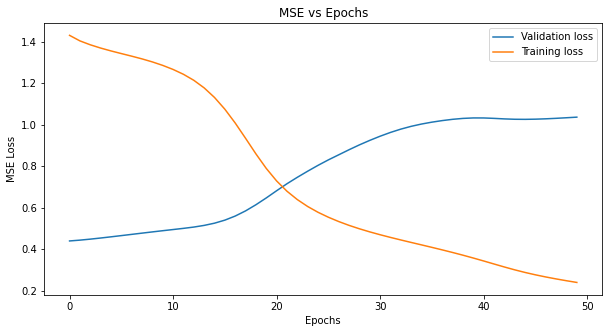

In [56]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(losses['Val'], label="Validation loss")
plt.plot(losses['Train'], label= "Training loss")
plt.xlabel('Epochs')
plt.ylabel("MSE Loss")
plt.title("MSE vs Epochs")
plt.legend()
plt.show()

NameError: name 'losses' is not defined

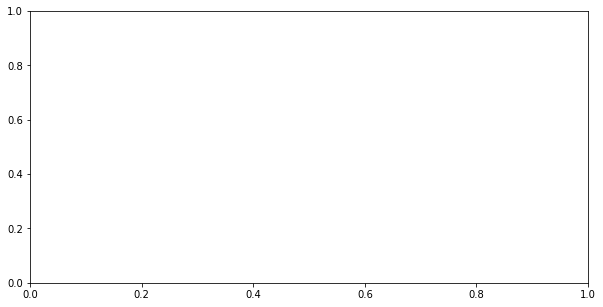

In [3]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(np.sqrt(losses['Val']), label="Validation loss")
plt.plot(np.sqrt(losses['Train']), label= "Training loss")
plt.xlabel('Epochs')
plt.ylabel("RMSE Loss")
plt.title("RMSE vs Epochs")
plt.legend()

plt.show()

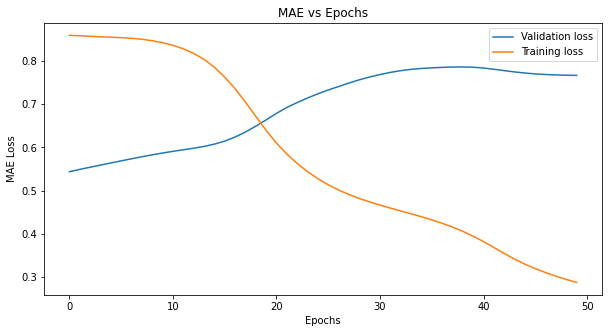

In [58]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(losses['Val_mae'], label="Validation loss")
plt.plot(losses['Train_mae'], label= "Training loss")
plt.xlabel('Epochs')
plt.ylabel("MAE Loss")
plt.title("MAE vs Epochs")
plt.legend()
plt.show()